In [1]:
#Import Libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn

In [2]:
# Datasets to train 
datasetNames = ["CIFAR10", "MNIST", "FashionMNIST","Moon_Craters"] 

In [4]:
code = 1
BATCH_SIZE=4

In [5]:
# Define data transformations for different datasets

if code ==1:
    # For CIFAR-10 dataset
    NUM_CHANNELS = 3

    # Define transformations for CIFAR-10
    transform = transforms.Compose(
    
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])
    


    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=2)


# For MNIST dataset
if code ==2:

    NUM_CHANNELS = 1

    # Define transformations for MNIST
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
        ])

    trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)


    testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

# For Fashion MNIST dataset
if code ==3:

    NUM_CHANNELS = 1


    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
        ])

    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)


    testset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


(3, 36, 138)


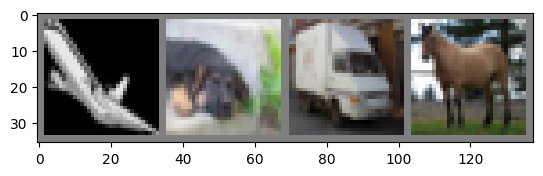

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an imageindices

def imshow(img):
    if code==1:
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
# Define a module for global average pooling
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        # Constructor method for initializing the module
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, x):
        return nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)

In [8]:
# Define a  module for 2D unpooling
class MyUnpool2d(nn.Module):
    def __init__(self, scale_factor):
        super(MyUnpool2d, self).__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return nn.functional.interpolate(x, scale_factor=self.scale_factor, mode='nearest')

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.conv1 = nn.Conv2d(NUM_CHANNELS, 64, 5)
        self.pool = nn.MaxPool2d(2, stride=2, return_indices=True)                                    
        self.conv2 = nn.Conv2d(64, 128, 5)

        # Fully connected layers for encoding
        self.fcEnc = nn.Sequential(
                                    nn.Linear(128 * 10 * 10, 120),
                                    nn.ReLU(True),
                                    nn.Linear(120, 84),
                                    nn.ReLU(True),
                                    nn.Linear(84, 40))
        
        # Decoder layers
        self.unpool = nn.MaxUnpool2d(2, stride=2, padding=0)

        

        self.fcDec = nn.Sequential(
                                    nn.Linear(40, 84),
                                    nn.ReLU(True),
                                    nn.Linear(84, 120),
                                    nn.ReLU(True),
                                    nn.Linear(120, 128 * 10 * 10),
                                    nn.ReLU(True),
                                    nn.Unflatten(1, (128, 10, 10))

        )

        # Transposed convolutional layer 1
        self.convt1 = nn.ConvTranspose2d(128, 64, 5)
        self.unpool = nn.MaxUnpool2d(2, 2)# Transposed convolutional layer 2
                        
        
                                    
        self.convt2 =  nn.ConvTranspose2d(64, NUM_CHANNELS, 5)




    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x,indices = self.pool(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = self.fcEnc(x)
        # Decoder
        x = self.fcDec(x)
        # print(x.shape)

        x = F.relu(self.convt1(x))
        x = self.unpool(x,indices)
        x = F.sigmoid( self.convt2(x))
        
        # print(x.shape)
        return x


    def compress(self,x):
        x = self.conv1(x)
        x,indices = self.pool(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = self.fcEnc(x)
        return x , indices
    
    def decompress(self,compressed,indices):
        # Decoding from compressed representation
        x = self.fcDec(compressed)

        x = F.relu(self.convt1(x))
        x = self.unpool(x,indices)
        x = F.sigmoid( self.convt2(x))
        
        # print(x.shape)
        return x
# Instantiate the autoencoder network

net = Autoencoder()


In [10]:
# import torch.optim as optim

# criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
net.to(device)

Autoencoder(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fcEnc): Sequential(
    (0): Linear(in_features=12800, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=40, bias=True)
  )
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (fcDec): Sequential(
    (0): Linear(in_features=40, out_features=84, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=84, out_features=120, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=120, out_features=12800, bias=True)
    (5): ReLU(inplace=True)
    (6): Unflatten(dim=1, unflattened_size=(128, 10, 10))
  )
  (convt1): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (convt2):

In [13]:
input_data = torch.randn(1, NUM_CHANNELS, 32, 32).to(device)  # Example input tensor of shape (batch_size, channels, height, width)
output_data = net(input_data)  # Forward pass through the autoencoder
# loss = F.mse_loss(output_data, input_data)  # Compute MSE loss between output and input
# print(loss)

In [14]:
output_data.shape

torch.Size([1, 3, 32, 32])

In [15]:
from tqdm import tqdm

In [16]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm


# Define the loss function (Mean Squared Error)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)


# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)  

for epoch in range(6):  # Train for 6 epochs

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        # Get the inputs and labels from the data loader
        inputs, labels = data

        optimizer.zero_grad()
        
        outputs = net(inputs.to(device))
        loss = criterion(outputs, inputs.to(device))
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item()
        # Print statistics every 2000 mini-batches
        if i % 2000 == 1999:   
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    
    
    # scheduler.step()

print('Finished Training')


1184it [00:03, 339.17it/s]


KeyboardInterrupt: 

## Saving the Model

In [ ]:
from datetime import datetime
now = datetime.now()

In [ ]:
f'{now}'

In [ ]:
root = 'models'

In [ ]:
f'{loss.item():.4f}'

In [ ]:
f'{root}/{datasetNames[code-1]}-{now}-{loss.item():.4f}.pth'

In [ ]:
torch.save(net.state_dict(), f'{root}/{datasetNames[code-1]}-{now}-{loss.item():.4f}.pth')

## Loading the saved model

In [19]:
import os

print(f"Options Are: {os.listdir('models')}")

Options Are: ['MNIST-2024-04-13 23:34:19.095483-0.0007.pth', 'MNIST-2024-04-12 22:36:39.511709-0.0010.pth', 'Moon_Craters-2024-04-13 02:48:53.422161-0.0060.pth', 'Moon_Craters-2024-04-13 02:19:45.432084-0.0063.pth', 'Moon_Craters-2024-04-13 01:32:40.360655-0.0253.pth', 'Moon_Craters-2024-04-13 18:56:05.024679-0.0009.pth', 'FashionMNIST-2024-04-12 22:44:18.962585-0.0025.pth', 'Moon_Craters-2024-04-13 05:02:58.809573-0.0026.pth', 'CIFAR10-2024-04-13 23:39:45.200790-0.1501.pth', 'CIFAR10-2024-04-12 23:05:46.035186-0.1568.pth', 'Moon_Craters-2024-04-13 01:45:10.732340-0.0453.pth', 'Moon_Craters-2024-04-13 01:36:45.303256-0.0250.pth', 'FashionMNIST-2024-04-13 22:51:17.457683-0.0037.pth', 'Moon_Craters-2024-04-13 21:32:40.449914-0.0031.pth', 'Moon_Craters-2024-04-13 02:49:20.415492-0.0105.pth', 'Moon_Craters-2024-04-13 02:06:39.657056-0.0080.pth', 'Moon_Craters-2024-04-13 02:21:16.453948-0.0061.pth']


In [20]:
net.load_state_dict(torch.load(f'models/CIFAR10-2024-04-13 23:39:45.200790-0.1501.pth'))

<All keys matched successfully>

(3, 36, 138)


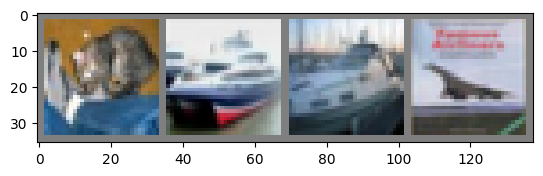

In [21]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))


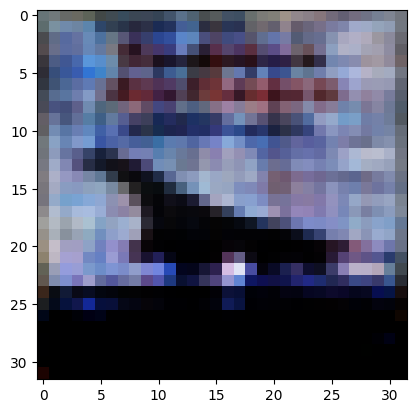

In [22]:

# Create an iterator from the test data loader

dataiter = iter(testloader)
# Retrieve a batch of images and their corresponding labels

images, labels = next(dataiter)

# Display the images in a grid

outputs = net(images.to(device))

plt.imshow(outputs[3].detach().cpu().permute(1,2,0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


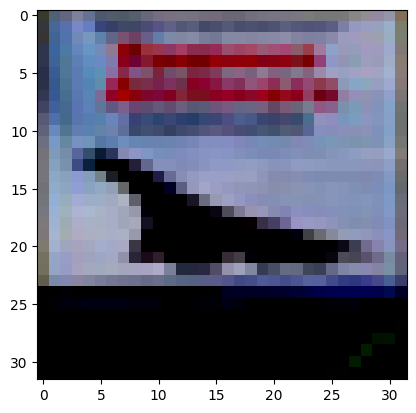

In [23]:
plt.imshow(images[3].detach().cpu().permute(1,2,0))

## Benchmarking on Test Dataset

In [24]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

# Define the loss function (Mean Squared Error)

criterion = nn.MSELoss()

running_loss = 0.0

# Iterate over the test data loader

for i, data in tqdm(enumerate(testloader, 0)):
    inputs, labels = data

    outputs = net(inputs.to(device))
    loss = criterion(outputs, inputs.to(device))

# Print the test loss
print(f'Test Loss: {loss.item()}')

2500it [00:01, 1633.57it/s]

Test Loss: 0.2165670096874237


## SSIM

In [25]:
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim

# Define the loss function (Mean Squared Error)

criterion = nn.MSELoss()

# Initialize variables for tracking loss and MSSIM

running_loss = 0.0

tSSIM = 0

# Iterate over the training data loader

for i, data in tqdm(enumerate(trainloader, 0)):
    inputs, labels = data

    # Pass the inputs through the autoencoder model to get the outputs
    outputs = net(inputs.to(device))

    # Convert tensors to numpy arrays and rearrange dimensions for SSIM calculation
    batchNumpyIP = inputs.permute((0,2,3,1)).detach().cpu().numpy()
    batchNumpyOP = outputs.permute((0,2,3,1)).detach().cpu().numpy()

    # Iterate over each sample in the batch
    for i in range(BATCH_SIZE):
        ssim_index, _ = compare_ssim(batchNumpyIP[i,:,:,0], batchNumpyOP[i,:,:,0], full=True,win_size=5,data_range=1)
        tSSIM+=ssim_index

    loss = criterion(outputs, inputs.to(device))

# Print the training loss and the mean MSSIM

print(f'Train Loss: {loss.item()}')
print(f'Mean MSSIM for Train data is: {tSSIM/(4*len(trainloader))}')


12500it [00:12, 978.68it/s] 

Train Loss: 0.12454616278409958
Mean MSSIM for Train data is: 0.2567739632328858


In [26]:
tSSIM

12838.698161644292

In [27]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

# Initialize an empty tensor to store compressed representations
resFull = torch.tensor([])


running_loss = 0.0
for i, data in tqdm(enumerate(trainloader, 0)):
    inputs, labels = data

    outputs = net.compress(inputs.to(device))
    # Concatenate the compressed representations to the `resFull` tensor
    resFull = torch.cat([resFull, outputs[0].detach().cpu()], dim=0)


12500it [00:10, 1220.45it/s]


In [28]:
resFull.shape

torch.Size([50000, 40])

In [29]:
toSave = resFull.numpy()

In [30]:
np.save(f'{datasetNames[code-1]}-compressed.npy',toSave)

Saving Inputs / Untouched

In [31]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

# Initialize an empty tensor to store the input data
resFull = torch.tensor([])


running_loss = 0.0
# Iterate over the training data loader
for i, data in tqdm(enumerate(trainloader, 0)):
    inputs, labels = data

    # outputs = net.compress(inputs.to(device))
    # Concatenate the input data tensors to the `resFull` tensor
    resFull = torch.cat([resFull, inputs], dim=0)


12500it [05:09, 40.40it/s]


In [32]:
resFull.shape

torch.Size([50000, 3, 32, 32])

In [33]:
toSave = resFull.numpy()

In [32]:
np.save(f'{datasetNames[code-1]}-og.npy',toSave)